In [1]:
import numpy as np
import pickle
hopper_data = {}
for k in [1, 2, 5, 10]:
    with open('k%d_stats.pkl' % k, 'rb') as f:
        hopper_data[k] = pickle.load(f)
        
data_keys = [
    'rew_by_head',
    'loss_by_head',
    'kl_by_head',
    'ev_by_head'
]

hopper_data[1].keys()

dict_keys(['program_args', 'loss_y_by_head', 'kl_y_by_head', 'evalrew_y', 'rew_x_by_head', 'evalrew_head_idx', 'ev_after_y', 'evalrew_x', 'rew_y_by_head', 'ev_before_y', 'iter_x'])

In [9]:
import matplotlib.pyplot as plt
import seaborn

desired_kl = 2e-3
def plot_unpickled_data(data, bootstrap_heads, skip=[], avgpast=100):
    fig, axes = plt.subplots(5, 1, figsize=(7, 8))
    evalrew_ax, rew_ax, loss_ax, kl_ax, ev_ax = axes
    plt.tight_layout(pad=2.0, h_pad=1.5)

    
    rew_ax.set_title('Average Reward (Rollout Head)')
    rew_x_by_head = data['rew_x_by_head']
    rew_y_by_head = data['rew_y_by_head']
    for i in range(bootstrap_heads):
        rew_x, rew_y = rew_x_by_head[i], rew_y_by_head[i]
        rew_ax.plot(rew_x, rew_y, marker='.')
        
    evalrew_ax.set_title('Evaluation Reward (Best Head)')
    evalrew_x = data['evalrew_x']
    evalrew_y = data['evalrew_y']
    evalrew_ax.plot(evalrew_x, evalrew_y, marker='.')
            

    iter_x = data['iter_x']
    
    if 'loss' in skip:
        loss_ax.remove()
    else:
        loss_ax.set_title('Loss (After train iteration, by head)')
        loss_y_by_head = data['loss_y_by_head']
        for i in range(bootstrap_heads):
            loss_y = loss_y_by_head[i]
            loss_ax.plot(iter_x, loss_y)

    kl_ax.set_title('KL')
    kl_y_by_head = data['kl_y_by_head']
    for i in range(bootstrap_heads):
        kl_y = kl_y_by_head[i]
        kl_ax.plot(iter_x, kl_y) 

    ev_ax.set_title('Explained Variance (After update, by head)')
    ev_ax.set_ylim(-1, 1)
    ev_before_y = data['ev_before_y']
    ev_after_y = data['ev_after_y']
    ev_ax.plot(iter_x, ev_before_y)
    ev_ax.plot(iter_x, ev_after_y)

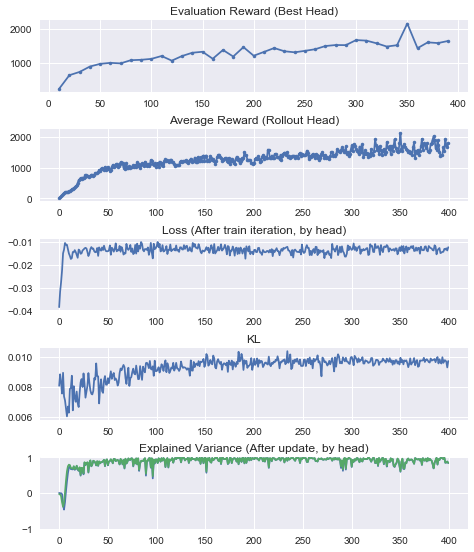

In [11]:
plot_unpickled_data(hopper_data[1], 1)
plt.show()

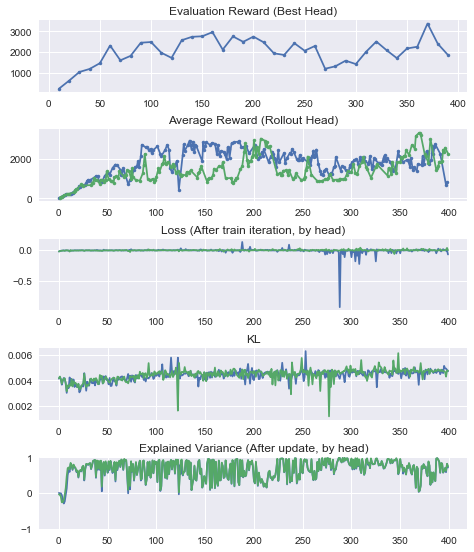

In [12]:
plot_unpickled_data(hopper_data[2], 2)
plt.show()

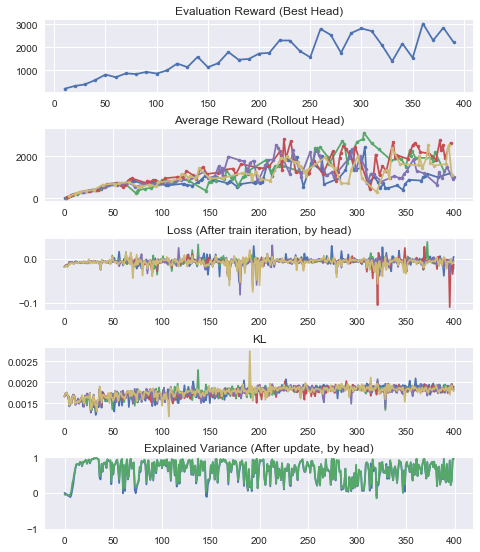

In [13]:
plot_unpickled_data(hopper_data[5], 5, avgpast=70)
plt.show()

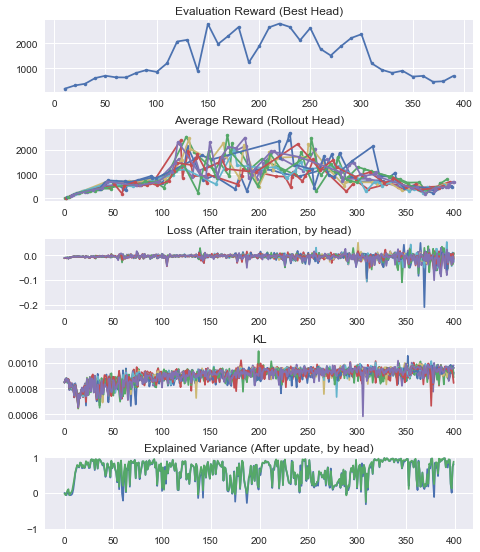

In [14]:
plot_unpickled_data(hopper_data[10], 10, avgpast=30)
plt.show()

In [25]:
def smooth_ts(ts, nback=100):
    smoothed = np.empty(len(ts) - nback)
    for i, t in enumerate(range(nback, len(ts))):
        smoothed[i] = np.mean(ts[t-nback:t])
    return smoothed

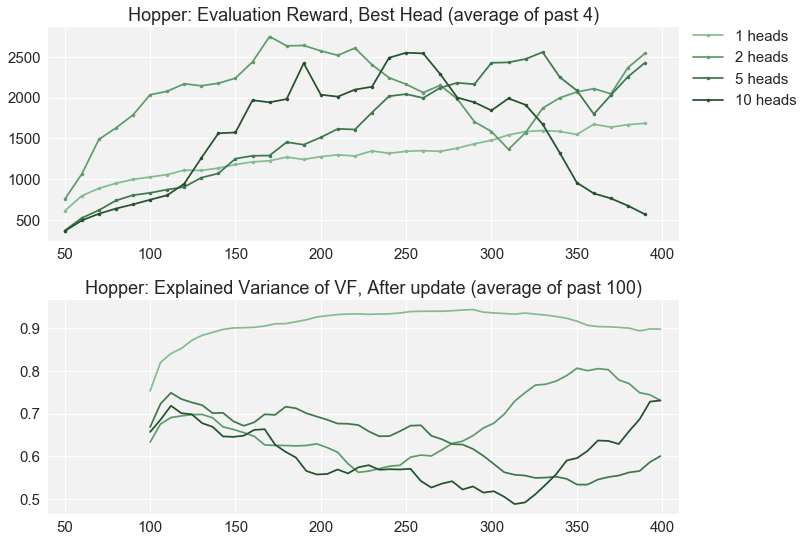

In [85]:
import seaborn as sns
from scipy.interpolate import spline

sns.set_style("darkgrid", {"axes.facecolor": ".95"})
with sns.cubehelix_palette(4, start=2, rot=0, dark=.25, light=.65):
    with sns.plotting_context("notebook", font_scale=1.5):
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        evalrew_ax, ev_ax = axes
        for ax in axes:
            ax.set_xlim(40, 410)

        evalrew_smooth_nback = 4
        evalrew_ax.set_title('Hopper: Evaluation Reward, Best Head (average of past {})'.format(evalrew_smooth_nback))
        for num_heads, data in sorted(hopper_data.items()): 
            evalrew_y = data['evalrew_y']
            smoothed_evalrew_y = smooth_ts(evalrew_y, evalrew_smooth_nback)
            evalrew_x = data['evalrew_x'][evalrew_smooth_nback:]
            evalrew_ax.plot(evalrew_x, smoothed_evalrew_y, marker='.', label='{} heads'.format(num_heads))
        evalrew_ax.legend(bbox_to_anchor=(1.0, 1.05))

        ev_smooth_nback = 100
        ev_ax.set_title('Hopper: Explained Variance of VF, After update (average of past {})'.format(ev_smooth_nback))
        for num_heads, data in sorted(hopper_data.items()):
            ev_after_y = data['ev_after_y']
            smoothed_ev = smooth_ts(ev_after_y, ev_smooth_nback)
            iter_x = data['iter_x'][ev_smooth_nback:]
            spline_points = 50
            xnew = np.linspace(min(iter_x), max(iter_x), spline_points)
            spline_ev = spline(iter_x, smoothed_ev, xnew)
            ev_ax.plot(xnew, spline_ev, label='{} heads'.format(num_heads))
            
plt.tight_layout(pad=2.0, h_pad=1.5)
plt.show()